In [96]:
# import text process tools
'''
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
'''
import pandas as pd
# import neural network tools
# tensorflow version: 2.10.1
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
# import mathematic tools
import numpy as np
# import illustration tools
import matplotlib.pyplot as plt
# import other python modules
import os
from itertools import chain
from functools import partial
import ast

In [97]:
# initial settings
seed = 0
tf.random.set_seed(seed)

In [98]:
# load data to dictionary of topic : dataframe
data = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    # need to install openpyxl module
    data[topic] = pd.read_excel('tokenized_' + topic + '.xlsx')[['text', 'token', 'score']]
    # turn strings of tokens into token lists
    data[topic]['token'] = data[topic]['token'].map(ast.literal_eval)

In [99]:
print('Here are some examples of data: ')
print('Text: ' + data['answers']['text'][0])
print('Tokens: ' + str(data['answers']['token'][0]))
print('Score: ' + str(data['answers']['score'][0]))

Here are some examples of data: 
Text: tell him repeatedly that big boys sleep in their own beds .
Tokens: ['tell', 'him', 'repeatedly', 'that', 'big', 'boys', 'sleep', 'in', 'their', 'own', 'beds', '.']
Score: -1.4


In [100]:
print('The maximum score for text is: ' + str(max(data['answers']['score'])))
print('The minimum score for text is: ' + str(min(data['answers']['score'])))

The maximum score for text is: 3.0
The minimum score for text is: -3.0


Distribution of score for answer text: 


(array([438., 635., 800., 754., 736., 657., 595., 168., 149.,  45.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

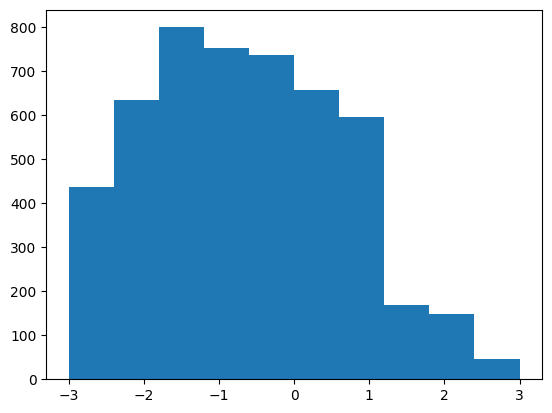

In [101]:
print('Distribution of score for answer text: ')
plt.hist(data['answers']['score'])

Distribution of score for blogs text: 


(array([ 11.,  52., 111., 192., 193., 357., 383., 322., 177.,  23.]),
 array([-3.  , -2.44, -1.88, -1.32, -0.76, -0.2 ,  0.36,  0.92,  1.48,
         2.04,  2.6 ]),
 <BarContainer object of 10 artists>)

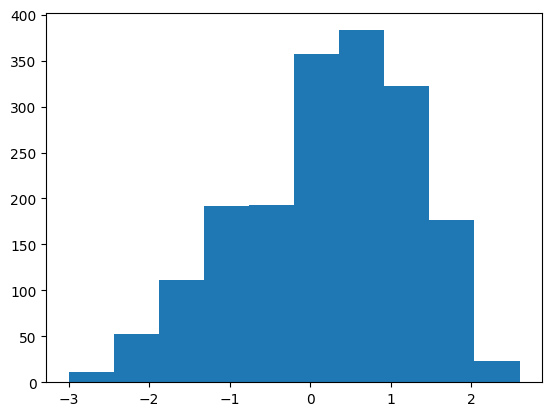

In [102]:
print('Distribution of score for blogs text: ')
plt.hist(data['blogs']['score'])

Distribution of score for emails text: 


(array([ 45.,  69., 134., 134., 173., 267., 295., 223., 231., 130.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

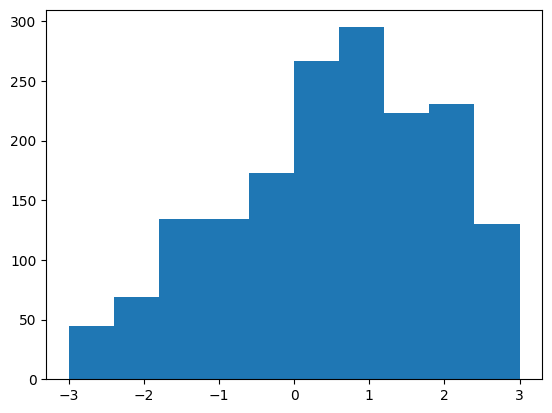

In [103]:
print('Distribution of score for emails text: ')
plt.hist(data['emails']['score'])

Distribution of score for news text: 


(array([  6.,  27.,  91., 133., 364., 609., 538., 682., 308.,  17.]),
 array([-2.6 , -2.06, -1.52, -0.98, -0.44,  0.1 ,  0.64,  1.18,  1.72,
         2.26,  2.8 ]),
 <BarContainer object of 10 artists>)

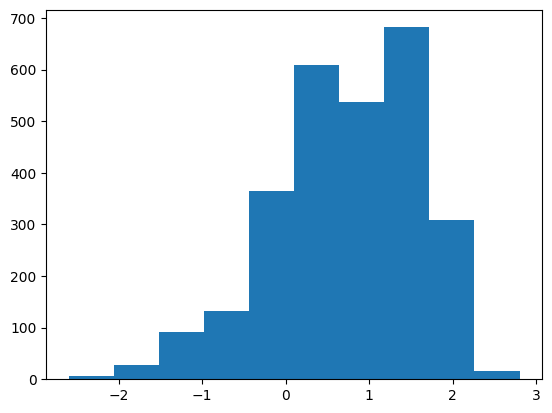

In [104]:
print('Distribution of score for news text: ')
plt.hist(data['news']['score'])

In [105]:
# get feature and label, in dictionaries of topic : data
tokens = {}
labels = {}
multi_labels = {}
equal_labels = {}
multi_labels_one_hot = {}
equal_labels_one_hot = {}

# different ways of labelling

def score_to_label(x):
    # label formal or informal
    if x > 0:
        return 1
    return 0

def score_to_more_labels(x):
    # label by extents of formality
    if x > -3 + 6 / 7 * 6:
        return 3
    elif x > -3 + 6 / 7 * 5:
        return 2
    elif x > -3 + 6 / 7 * 4:
        return 1
    elif x > -3 + 6 / 7 * 3:
        return 0
    elif x > -3 + 6 / 7 * 2:
        return -1
    elif x > -3 + 6 / 7 * 1:
        return -2
    else:
        return -3
    
def proportion_to_labels(splited_score, x):
    # label 7 labels to equal amount of tokens
    for i in range(len(splited_score)):
        # label score according to which slice it is in
        if x <= splited_score[i][-1]:
            return i - 3
    return 3
    
def num_to_seq(x):
    # numbers to one-hot vectors
    return [1 if i == x else 0 for i in range(-3, 4)]

for topic in ('answers', 'blogs', 'emails', 'news'):
    # get tokens and scores
    tokens[topic] = list(data[topic]['token'])
    labels[topic] = list(data[topic]['score'].map(score_to_label))
    multi_labels[topic] = data[topic]['score'].map(score_to_more_labels)
    equal_labels[topic] = data[topic]['score'].map(partial(proportion_to_labels, np.array_split(np.sort(data[topic]['score']), 7)))
    multi_labels_one_hot[topic] = list(multi_labels[topic].map(num_to_seq))
    equal_labels_one_hot[topic] = list(equal_labels[topic].map(num_to_seq))

In [106]:
print('An example of token and label: ')
print('Tokens: ' + str(tokens['blogs'][0]))
print('Label: ' + str(labels['blogs'][0]))

An example of token and label: 
Tokens: ['The', 'crawler', '-', 'transporter', 'will', 'carry', 'the', 'rocket', 'on', 'the', '4.2', '-', 'mile', 'journey', 'to', 'Launch', 'Pad', '39B', '.']
Label: 1


Example of distribution of labels by formal or not for answers text: 


(array([3604.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1373.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

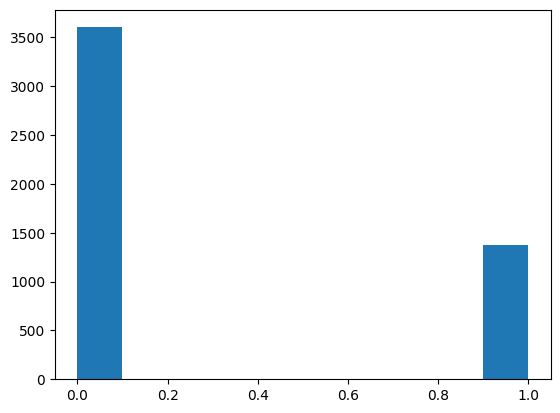

In [107]:
print('Example of distribution of labels by formal or not for answers text: ')
plt.hist(labels['answers'])

Example of distribution of labels by degree of formality for answers text: 


(array([ 817., 1036., 1022., 1128.,  617.,  357.]),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 6 artists>)

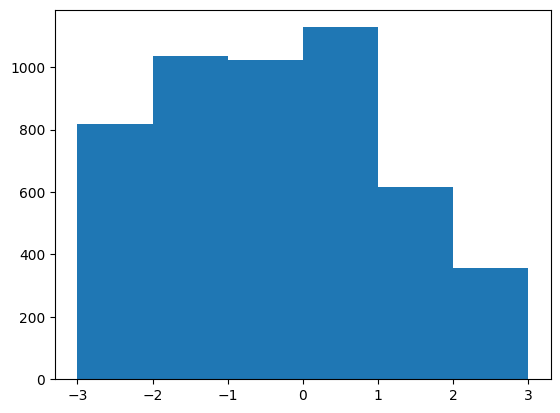

In [108]:
print('Example of distribution of labels by degree of formality for answers text: ')
plt.hist(multi_labels['answers'], bins=[i for i in range(-3, 4)])

Example of distribution of labels by data distribution for answers text: 


(array([ 817.,  768.,  795.,  476.,  748., 1373.]),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 6 artists>)

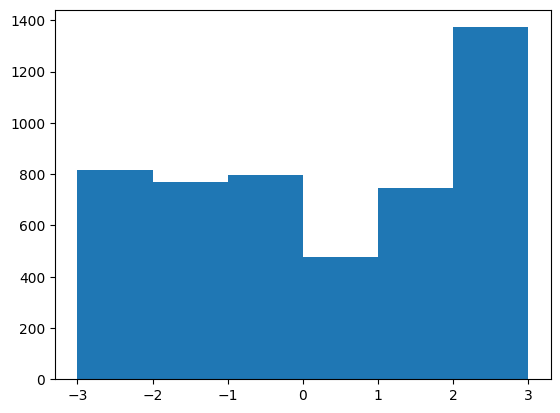

In [109]:
print('Example of distribution of labels by data distribution for answers text: ')
plt.hist(equal_labels['answers'], bins=[i for i in range(-3, 4)])

In [110]:
# construct text from tokens, as later may add processing to tokens, which changes text
# text is used in dataset
features = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    features[topic] = list(map(lambda s: ' '.join(s), tokens[topic]))

In [111]:
print('An example of text: ' + features['blogs'][0])

An example of text: The crawler - transporter will carry the rocket on the 4.2 - mile journey to Launch Pad 39B .


In [112]:
# generate datasets of (text, label) stored in dictionary of topic : dataset
dataset = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    dataset[topic] = tf.data.Dataset.from_tensor_slices((features[topic], multi_labels_one_hot[topic]))

In [113]:
print('Here are some examples of data in dataset: ')
arrayed_dataset = np.array(list(dataset['emails'].as_numpy_iterator()), dtype=object)
print(arrayed_dataset[:3, :])

Here are some examples of data in dataset: 
[[b"We tried to run a similar piece , which apparently the Post did n't like ."
  array([0, 0, 1, 0, 0, 0, 0])]
 [b'It worries and upsets me that this bill has been passed .'
  array([0, 0, 1, 0, 0, 0, 0])]
 [b'I know you realize the importance of this appointment .'
  array([0, 0, 0, 0, 1, 0, 0])]]
[[b"I 'll have more tomorrow ." array([1, 0, 0, 0, 0, 0, 0])]
 [b'BlackBerry.net )' array([1, 0, 0, 0, 0, 0, 0])]
 [b'so now its like starting all over again .'
  array([1, 0, 0, 0, 0, 0, 0])]]


In [114]:
# split evaluation dataset from experiment dataset, the proportion is 2 : 8, still in dictionary
dataset_experiment = {}
dataset_evaluation = {}
folds = {}

# split the dataset to 5 folds
def split_dataset(dataset):
    new_dataset = dataset.shuffle(1000000)
    folds = []
    for i in range(5):
        folds.append(new_dataset.shard(num_shards=5, index=i))
    return folds
   
# split evaluation and experiment dataset and split into folds
for topic in ('answers', 'blogs', 'emails', 'news'):
    data_size = len(list(dataset[topic]))
    dataset[topic] = dataset[topic].shuffle(1000000)
    dataset_experiment[topic] = dataset[topic].take(int(data_size * 0.8))
    dataset_evaluation[topic] = dataset[topic].skip(int(data_size * 0.2))
    
    folds[topic] = split_dataset(dataset_experiment[topic])

In [115]:
eval_dataset_by_label = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    eval_data = np.array(list(dataset_evaluation[topic].as_numpy_iterator()), dtype=object)
    eval_dataset_by_label[topic] = {}
    for i in range(-3, 4):
        to_be_added = {'features':[], 'multi_labels_one_hot':[]}
        for j in range(len(features[topic])):
            if multi_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:
                to_be_added['features'].append(features[topic][j])
                to_be_added['multi_labels_one_hot'].append(multi_labels_one_hot[topic][j])
        eval_dataset_by_label[topic][i] = tf.data.Dataset.from_tensor_slices((to_be_added['features'], to_be_added['multi_labels_one_hot']))

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\3986776.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if multi_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:


In [80]:
arrayed_splited_dataset = np.array(list(eval_dataset_by_label['emails'][-3].as_numpy_iterator()), dtype=object)
print(arrayed_splited_dataset[:3, :])

[[b"I 'll have more tomorrow ." array([1, 0, 0, 0, 0, 0, 0])]
 [b'BlackBerry.net )' array([1, 0, 0, 0, 0, 0, 0])]
 [b'so now its like starting all over again .'
  array([1, 0, 0, 0, 0, 0, 0])]]


In [20]:
# vocabulary setting
all_tokens = []
for topic in ('answers', 'blogs', 'emails', 'news'):
    for i in data[topic]['token']:
        for j in i:
            all_tokens.append(j)
print('Vocabulary size: ' + str(len(set(all_tokens))))

Vocabulary size: 20884


In [21]:
# construct an encoder for model
vocab = list(set(chain.from_iterable(all_tokens)))
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(vocab)

In [22]:
# basic implementation
# structure of model is changable
def get_model(layer, batch_size, num_class):
    # construct sequential model
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=batch_size,
            mask_zero=True, name='embedding'),
        layer,
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(batch_size, activation='relu', name='dense_batch'),
        tf.keras.layers.Dense(num_class, activation='relu', name='dense_output')
    ])
    # compile model
    model.compile(# use cross entropy loss
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                # fix learning rate of 0.001
                optimizer=tf.keras.optimizers.Adam(0.001),
                # evaluate the accuracy of labelling
                metrics=['accuracy'])
    return model

def train_and_test(model, epoch, train_dataset, test_dataset):
    # train the model with train dataset
    trained = model.fit(train_dataset, epochs=epoch)
    # test with test dataset
    return model.evaluate(test_dataset)[1]

def train_with_label_and_test(model, epoch, train_dataset, y, test_dataset):
    # train the model with train dataset
    trained = model.fit(train_dataset, y, epochs=epoch)
    # test with test dataset
    return model.evaluate(test_dataset)[1]

In [23]:
# get model
model_basic = get_model(tf.keras.layers.LSTM(32, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]))
model_basic.summary()

<ipython-input-23-0e79d6844b23>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_basic = get_model(tf.keras.layers.LSTM(32, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3008      
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_batch (Dense)         (None, 64)                2112      
                                                                 
 dense_output (Dense)        (None, 7)                 455       
                                                        

In [24]:
topic = 'answers'
accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(64).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(64).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    accuracy.append(train_and_test(model_basic, 40, train_dataset, test_dataset))

Epoch 1/40
13/13 [==============================] - 4s 12ms/step - loss: 1.9421 - accuracy: 0.1947
Epoch 2/40
13/13 [==============================] - 0s 11ms/step - loss: 1.9175 - accuracy: 0.2261
Epoch 3/40
13/13 [==============================] - 0s 11ms/step - loss: 1.8686 - accuracy: 0.2374
Epoch 4/40
13/13 [==============================] - 0s 11ms/step - loss: 1.8331 - accuracy: 0.2362
Epoch 5/40
13/13 [==============================] - 0s 11ms/step - loss: 1.8125 - accuracy: 0.2475
Epoch 6/40
13/13 [==============================] - 0s 10ms/step - loss: 1.8042 - accuracy: 0.2412
Epoch 7/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7718 - accuracy: 0.2111
Epoch 8/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7842 - accuracy: 0.2198
Epoch 9/40
13/13 [==============================] - 0s 11ms/step - loss: 1.8012 - accuracy: 0.2286
Epoch 10/40
13/13 [==============================] - 0s 11ms/step - loss: 1.7822 - accuracy: 0.2312
Epoch 11/

13/13 [==============================] - 0s 10ms/step - loss: 1.6958 - accuracy: 0.2785
Epoch 2/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7042 - accuracy: 0.2710
Epoch 3/40
13/13 [==============================] - 0s 11ms/step - loss: 1.6845 - accuracy: 0.2685
Epoch 4/40
13/13 [==============================] - 0s 11ms/step - loss: 1.7316 - accuracy: 0.2597
Epoch 5/40
13/13 [==============================] - 0s 11ms/step - loss: 1.6912 - accuracy: 0.2748
Epoch 6/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7093 - accuracy: 0.2547
Epoch 7/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7150 - accuracy: 0.2447
Epoch 8/40
13/13 [==============================] - 0s 10ms/step - loss: 1.6966 - accuracy: 0.2861
Epoch 9/40
13/13 [==============================] - 0s 10ms/step - loss: 1.6971 - accuracy: 0.2760
Epoch 10/40
13/13 [==============================] - 0s 10ms/step - loss: 1.7325 - accuracy: 0.2597
Epoch 11/40
13/13 [=

In [25]:
print(accuracy)

[0.2735257148742676, 0.286432147026062, 0.28894472122192383, 0.30402010679244995, 0.2989949882030487]


In [26]:
# try interpretability
sample_text = data[topic]['text'][2]
sample_token = data[topic]['token'][2]
print(sample_text)
print(sample_token)

def convolution_predict(token, model, window, mode=0):
    # mode 0: return subtext that has closest score to text for binary label
    # mode 1: return subtext that has highest score in same direction with text for binary label
    # mode 2: return subtext that has closest score to text for multi label
    # mode 3: return subtext that has highest score in same direction with text for multi label
    text = ' '.join(token)
    token_windows = [token[i:i+window] for i in range(len(token)-window+1)]
    text_windows = list(map(lambda x: ' '.join(x), token_windows))
    prediction = model.predict([text])[0]
    window_prediction = model.predict(text_windows)
    if mode == 0:
        result = np.argmin(np.sum(np.absolute(window_prediction - prediction), axis=1))
    elif mode == 1:
        result = np.argmax(np.sum(window_prediction * prediction, axis=1))
    elif mode == 2:
        result = np.argmin(np.sum(np.absolute(window_prediction - prediction), axis=1))
    elif mode == 3:
        result = np.argmax(window_prediction[:, np.argmax(prediction)])
    # get window of subtext of best similarity to original text
    cause = text_windows[result]
    return cause, (np.argmax(prediction) - 3)
    
interpret = convolution_predict(sample_token, model_basic, 5, mode=1)
print('''The text "''' + sample_text + '''" is ''' + ['informal', 'formal'][int(interpret[1])] + ' as it contains: ')
print(interpret[0])

Good Luck and do n't give up !
['Good', 'Luck', 'and', 'do', "n't", 'give', 'up', '!']
1/1 [==============================] - 0s 41ms/step
The text "Good Luck and do n't give up !" is informal as it contains: 
do n't give up !


In [ ]:
# bert implementation
# download models in https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3 and https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
preprocessor = hub.KerasLayer('bert_en_uncased_preprocess_3', name='preprocess')
bert_layer = hub.KerasLayer('small_bert_bert_en_uncased_L-2_H-128_A-2_2', trainable=True, name='bert')

In [ ]:
def get_bert_model(batch_size, num_class):
    # cannot use Sequential(), manually construct the model
    i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')
    x = preprocessor(i)
    x = bert_layer(x)
    x = x['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(batch_size, activation='relu', name='dense_batch')(x)
    x = tf.keras.layers.Dense(num_class, activation='relu', name='dense_output')(x)
    model = tf.keras.Model(i, x)
    model.compile(# use cross entropy loss
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                # fix learning rate of 0.001
                optimizer=tf.keras.optimizers.Adam(0.001),
                # evaluate the accuracy of labelling
                metrics=['accuracy'])
    return model

In [ ]:
# try bert model
model_bert = get_bert_model(64, len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]))
model_bert.summary()

In [ ]:
topic = 'answers'
accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(64).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(64).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    accuracy.append(train_and_test(model_bert, 40, train_dataset, test_dataset))

In [ ]:
print(accuracy)

In [ ]:
interpret = convolution_predict(sample_token, model_bert, 5, mode=1)
print('''The text "''' + sample_text + '''" is ''' + ['informal', 'formal'][int(interpret[1])] + ' as it contains: ')
print(interpret[0])

# Evaluation With Balanced And Unbalanced labels

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3008      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_batch (Dense)         (None, 64)                8256      
                                                                 
 dense_output (Dense)        (None, 7)                 455       
                                                     

13/13 [==============================] - 0s 30ms/step - loss: 1.6972 - accuracy: 0.2673
Epoch 30/40
13/13 [==============================] - 0s 29ms/step - loss: 1.6797 - accuracy: 0.2836
Epoch 31/40
13/13 [==============================] - 0s 29ms/step - loss: 1.6905 - accuracy: 0.2886
Epoch 32/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6847 - accuracy: 0.2848
Epoch 33/40
13/13 [==============================] - 0s 29ms/step - loss: 1.6832 - accuracy: 0.2949
Epoch 34/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6925 - accuracy: 0.2647
Epoch 35/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6699 - accuracy: 0.2823
Epoch 36/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6833 - accuracy: 0.2459
Epoch 37/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6638 - accuracy: 0.2560
Epoch 38/40
13/13 [==============================] - 0s 30ms/step - loss: 1.6787 - accuracy: 0.2610
Epoch 39/40


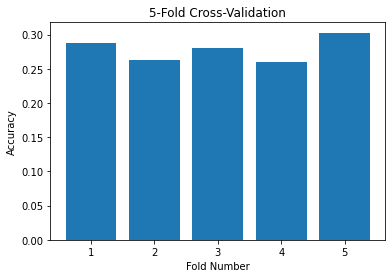

In [42]:
# get basic model used in sections above
model_basic = get_model(tf.keras.layers.LSTM(128, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
model_basic.summary()

topic = 'answers'

accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(64).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(64).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    accuracy.append(train_and_test(model_basic, 40, train_dataset, test_dataset))
print(accuracy)



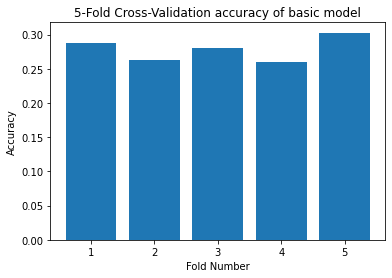

In [43]:
# Create the bar plot plotting the accuracy of the model on each fold during the 5-fold cross-validation process
fold_numbers = list(range(1, 6))
plt.bar(fold_numbers, accuracy)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation accuracy of basic model')
plt.show()

basic_model_accuracy = accuracy

In [27]:
# Advanced Test Model untuned 

def get_untune_test_model(num_class):
    
    # Set the dimension of the embeddings
    embedding_dim = 300    
    # construct sequential model
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=embedding_dim,
            mask_zero=True, name='embedding'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, name='lstm_1')),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm_2')),
        tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
        tf.keras.layers.Dropout(0.5, name='dropout_1'),
        tf.keras.layers.Dense(num_class, activation='softmax', name='dense_output')
    ])
    # compile model
    model.compile(# use cross entropy loss
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                # fix learning rate of 0.001
                optimizer=tf.keras.optimizers.Adam(0.004),
                # evaluate the accuracy of labelling
                metrics=['accuracy'])
    return model

def train_and_test(model, epoch, train_dataset, test_dataset):
    # train the model with train dataset
    trained = model.fit(train_dataset, epochs=epoch)
    # test with test dataset
    return model.evaluate(test_dataset)[1]

def train_with_label_and_test(model, epoch, train_dataset, y, test_dataset):
    # train the model with train dataset
    trained = model.fit(train_dataset, y, epochs=epoch)
    # test with test dataset
    return model.evaluate(test_dataset)[1]


In [34]:
test_model= get_untune_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
test_model.summary()

topic = 'answers'
accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(32).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(32).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(32).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    accuracy.append(train_and_test(model_basic, 40, train_dataset, test_dataset))
print(accuracy)



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_20 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

25/25 [==============================] - 0s 7ms/step - loss: 1.6422 - accuracy: 0.2873
Epoch 29/40
25/25 [==============================] - 0s 7ms/step - loss: 1.6286 - accuracy: 0.2848
Epoch 30/40
25/25 [==============================] - 0s 6ms/step - loss: 1.5776 - accuracy: 0.3551
Epoch 31/40
25/25 [==============================] - 0s 6ms/step - loss: 1.6345 - accuracy: 0.2873
Epoch 32/40
25/25 [==============================] - 0s 7ms/step - loss: 1.6130 - accuracy: 0.3350
Epoch 33/40
25/25 [==============================] - 0s 6ms/step - loss: 1.6347 - accuracy: 0.3275
Epoch 34/40
25/25 [==============================] - 0s 7ms/step - loss: 1.6567 - accuracy: 0.3099
Epoch 35/40
25/25 [==============================] - 0s 7ms/step - loss: 1.6057 - accuracy: 0.3262
Epoch 36/40
25/25 [==============================] - 0s 8ms/step - loss: 1.6234 - accuracy: 0.3187
Epoch 37/40
25/25 [==============================] - 0s 7ms/step - loss: 1.6515 - accuracy: 0.2836
Epoch 38/40
25/25 [===

In [ ]:
# Create the bar plot plotting the accuracy of the model on each fold during the 5-fold cross-validation process
fold_numbers = list(range(1, 6))
plt.bar(fold_numbers, accuracy)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation of advanced model')
plt.show()

untune_advanced_model_accuracy = accuracy

# Evaluating Various Hyperparameters Grid Search

In [31]:
# Advanced Test Model with more parameters to allow for tuning 

def get_test_model(num_class, embedding_dim_number, learning_rate, loss_function, optimizer, activation_function):
    
    # Set the dimension of the embeddings
    embedding_dim = embedding_dim_number    
    # construct sequential model
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=embedding_dim,
            mask_zero=True, name='embedding'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, name='lstm_1')),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm_2')),
        tf.keras.layers.Dense(64, activation=activation_function, name='dense_1'),
        tf.keras.layers.Dropout(0.5, name='dropout_1'),
        tf.keras.layers.Dense(num_class, activation='softmax', name='dense_output')
    ])

    # compile model
    model.compile(# use cross entropy loss
                loss=loss_function,
                optimizer=optimizer(learning_rate),
                # evaluate the accuracy of labelling
                metrics=['accuracy'])
    return model

In [29]:
# an example of searching, not actual search procedure
topic = 'answers'


# Hyperparameter search spaces
loss_functions_space = [
    tf.keras.losses.CategoricalCrossentropy(from_logits=False)
]

optimizers_space = [
    tf.keras.optimizers.SGD,
    tf.keras.optimizers.Adam,
]

activation_functions_space = [
    'relu'
]

learning_rates_space = [
    0.001,
]

epochs_space = [
    40
]

batch_sizes_space = [
    64
]

loss_function_names = ['Cross-Entropy']
optimizer_names = ['SGD', 'Adam']
activation_function_names = ['relu']
learning_rate_names = ['0.001']
epoch_names = ['40']
batch_size_names = ['64']

# Store the average accuracy for each combination of hyperparameters
average_accuracies = np.zeros((len(loss_functions_space), len(optimizers_space), len(activation_functions_space), len(learning_rates_space), len(epochs_space), len(batch_sizes_space)))

# Perform the hyperparameter search
# Nested loops for each hyperparameter search space

for i, loss_function in enumerate(loss_functions_space):
    for j, optimizer in enumerate(optimizers_space):
        for k, activation_function in enumerate(activation_functions_space):
            for l, learning_rate in enumerate(learning_rates_space):
                for m, num_epochs in enumerate(epochs_space):
                    for n, batch_size in enumerate(batch_sizes_space):
                        accuracy = []

                        for fold in range(5):
                            # Create a model with fixed LSTM units, dense units, and dropout rates, using the current hyperparameters
                            test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]),300,learning_rate, loss_function, optimizer, activation_function)

                            # One fold as test dataset
                            test_dataset = folds[topic][fold].batch(batch_size).prefetch(tf.data.AUTOTUNE)
                            iterator = [p for p in range(5) if p != fold]

                            # The rest as train dataset
                            train_dataset = folds[topic][iterator[0]].batch(batch_size).prefetch(tf.data.AUTOTUNE)
                            for p in iterator[1:]:
                                train_dataset = train_dataset.concatenate(folds[topic][p].batch(batch_size).prefetch(tf.data.AUTOTUNE))

                            # Train and test the model
                            accuracy.append(train_and_test(test_model, num_epochs, train_dataset, test_dataset))
 
                        # Calculate the average accuracy for this iteration
                        average_accuracy = np.mean(accuracy)
                        average_accuracies[i, j, k, l, m, n] = average_accuracy

                       

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_14900\2695792866.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]),300,learning_rate, loss_function, optimizer, activation_function)


Epoch 1/40
52/52 [==============================] - 10s 17ms/step - loss: 1.9478 - accuracy: 0.1567
Epoch 2/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9426 - accuracy: 0.1778
Epoch 3/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9376 - accuracy: 0.1840
Epoch 4/40
52/52 [==============================] - 1s 14ms/step - loss: 1.9331 - accuracy: 0.1894
Epoch 5/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9292 - accuracy: 0.1944
Epoch 6/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9240 - accuracy: 0.2082
Epoch 7/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9224 - accuracy: 0.1957
Epoch 8/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9169 - accuracy: 0.1916
Epoch 9/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9116 - accuracy: 0.2114
Epoch 10/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9111 - accuracy: 0.1991
Epoch 11

52/52 [==============================] - 10s 18ms/step - loss: 1.9405 - accuracy: 0.1962
Epoch 2/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9340 - accuracy: 0.2100
Epoch 3/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9301 - accuracy: 0.2057
Epoch 4/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9252 - accuracy: 0.2119
Epoch 5/40
52/52 [==============================] - 1s 19ms/step - loss: 1.9180 - accuracy: 0.2270
Epoch 6/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9164 - accuracy: 0.2182
Epoch 7/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9113 - accuracy: 0.2248
Epoch 8/40
52/52 [==============================] - 1s 17ms/step - loss: 1.9068 - accuracy: 0.2226
Epoch 9/40
52/52 [==============================] - 1s 15ms/step - loss: 1.9010 - accuracy: 0.2405
Epoch 10/40
52/52 [==============================] - 1s 17ms/step - loss: 1.8972 - accuracy: 0.2374
Epoch 11/40
52/52 [

52/52 [==============================] - 11s 17ms/step - loss: 1.8605 - accuracy: 0.2104
Epoch 2/40
52/52 [==============================] - 1s 19ms/step - loss: 1.7986 - accuracy: 0.2248
Epoch 3/40
52/52 [==============================] - 1s 16ms/step - loss: 1.7669 - accuracy: 0.2301
Epoch 4/40
52/52 [==============================] - 1s 19ms/step - loss: 1.7388 - accuracy: 0.2311
Epoch 5/40
52/52 [==============================] - 1s 17ms/step - loss: 1.7203 - accuracy: 0.2490
Epoch 6/40
52/52 [==============================] - 1s 16ms/step - loss: 1.7376 - accuracy: 0.2424
Epoch 7/40
52/52 [==============================] - 1s 18ms/step - loss: 1.7103 - accuracy: 0.2628
Epoch 8/40
52/52 [==============================] - 1s 16ms/step - loss: 1.7131 - accuracy: 0.2600
Epoch 9/40
52/52 [==============================] - 1s 20ms/step - loss: 1.7122 - accuracy: 0.2565
Epoch 10/40
52/52 [==============================] - 1s 19ms/step - loss: 1.7090 - accuracy: 0.2619
Epoch 11/40
52/52 [

In [39]:
# this is the real one
topic = 'answers'


# Hyperparameter search spaces
loss_functions_space = [
    tf.keras.losses.MeanSquaredError(),
    tf.keras.losses.CategoricalCrossentropy(from_logits=False)
]

optimizers_space = [
    tf.keras.optimizers.SGD,
    tf.keras.optimizers.Adam,
    tf.keras.optimizers.Adagrad,
]

activation_functions_space = [
    'relu',
    'sigmoid'
]

learning_rates_space = [
    0.001,
    0.01,
]

epochs_space = [
    32,
    48
]

batch_sizes_space = [
    64,
    128
]

loss_function_names = ['MSE', 'Cross-Entropy']
optimizer_names = ['SGD', 'Adam', 'Adagrad']
activation_function_names = ['relu', 'sigmoid']
learning_rate_names = ['0.001', '0.01']
epoch_names = ['32', '48']
batch_size_names = ['64', '128']

# Store the average accuracy for each combination of hyperparameters
average_accuracies = np.zeros((len(loss_functions_space), len(optimizers_space), len(activation_functions_space), len(learning_rates_space), len(epochs_space), len(batch_sizes_space)))

# Perform the hyperparameter search
# Nested loops for each hyperparameter search space
counter = 0
for i, loss_function in enumerate(loss_functions_space):
    for j, optimizer in enumerate(optimizers_space):
        for k, activation_function in enumerate(activation_functions_space):
            for l, learning_rate in enumerate(learning_rates_space):
                for m, num_epochs in enumerate(epochs_space):
                    for n, batch_size in enumerate(batch_sizes_space):
                        accuracy = []
                        counter += 1
                        print('This is trail ' + str(counter))
                        for fold in range(1):
                            # Create a model with fixed LSTM units, dense units, and dropout rates, using the current hyperparameters
                            test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]),300,learning_rate, loss_function, optimizer, activation_function)

                            # One fold as test dataset
                            test_dataset = folds[topic][fold].batch(batch_size).prefetch(tf.data.AUTOTUNE)
                            iterator = [p for p in range(5) if p != fold]

                            # The rest as train dataset
                            train_dataset = folds[topic][iterator[0]].batch(batch_size).prefetch(tf.data.AUTOTUNE)
                            for p in iterator[1:]:
                                train_dataset = train_dataset.concatenate(folds[topic][p].batch(batch_size).prefetch(tf.data.AUTOTUNE))

                            # Train and test the model
                            accuracy.append(train_and_test(test_model, num_epochs, train_dataset, test_dataset))
                        
                        # Calculate the average accuracy for this iteration
                        average_accuracy = np.mean(accuracy)
                        average_accuracies[i, j, k, l, m, n] = average_accuracy

                       

This is trail 1


C:\Users\LUCAS\AppData\Local\Temp\ipykernel_14900\406360682.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]),300,learning_rate, loss_function, optimizer, activation_function)


Epoch 1/32
52/52 [==============================] - 11s 22ms/step - loss: 0.1229 - accuracy: 0.0707
Epoch 2/32
52/52 [==============================] - 1s 15ms/step - loss: 0.1228 - accuracy: 0.0766
Epoch 3/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1228 - accuracy: 0.0810
Epoch 4/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1228 - accuracy: 0.0842
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1227 - accuracy: 0.0948
Epoch 6/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1228 - accuracy: 0.0848
Epoch 7/32
52/52 [==============================] - 1s 15ms/step - loss: 0.1227 - accuracy: 0.0986
Epoch 8/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1227 - accuracy: 0.0964
Epoch 9/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1227 - accuracy: 0.0955
Epoch 10/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1227 - accuracy: 0.1024
Epoch 11

52/52 [==============================] - 1s 17ms/step - loss: 0.1223 - accuracy: 0.2029
Epoch 18/48
52/52 [==============================] - 1s 16ms/step - loss: 0.1223 - accuracy: 0.2107
Epoch 19/48
52/52 [==============================] - 1s 18ms/step - loss: 0.1223 - accuracy: 0.2334
Epoch 20/48
52/52 [==============================] - 1s 17ms/step - loss: 0.1223 - accuracy: 0.2164
Epoch 21/48
52/52 [==============================] - 1s 16ms/step - loss: 0.1223 - accuracy: 0.2098
Epoch 22/48
52/52 [==============================] - 1s 19ms/step - loss: 0.1223 - accuracy: 0.2148
Epoch 23/48
52/52 [==============================] - 1s 15ms/step - loss: 0.1223 - accuracy: 0.2214
Epoch 24/48
52/52 [==============================] - 1s 17ms/step - loss: 0.1222 - accuracy: 0.2327
Epoch 25/48
52/52 [==============================] - 1s 15ms/step - loss: 0.1222 - accuracy: 0.2098
Epoch 26/48
52/52 [==============================] - 1s 15ms/step - loss: 0.1222 - accuracy: 0.2242
Epoch 27/48


52/52 [==============================] - 10s 19ms/step - loss: 0.1224 - accuracy: 0.1530
Epoch 2/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1222 - accuracy: 0.1916
Epoch 3/32
52/52 [==============================] - 1s 15ms/step - loss: 0.1221 - accuracy: 0.1872
Epoch 4/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1219 - accuracy: 0.2155
Epoch 5/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1219 - accuracy: 0.2035
Epoch 6/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1218 - accuracy: 0.1976
Epoch 7/32
52/52 [==============================] - 1s 21ms/step - loss: 0.1216 - accuracy: 0.1969
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1215 - accuracy: 0.1985
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1214 - accuracy: 0.2107
Epoch 10/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1214 - accuracy: 0.1938
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 22ms/step - loss: 0.1400 - accuracy: 0.1021
Epoch 2/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1380 - accuracy: 0.1153
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1391 - accuracy: 0.1168
Epoch 4/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1388 - accuracy: 0.1146
Epoch 5/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1385 - accuracy: 0.1143
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1379 - accuracy: 0.1149
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1364 - accuracy: 0.1319
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1372 - accuracy: 0.1275
Epoch 9/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1375 - accuracy: 0.1190
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1371 - accuracy: 0.1184
Epoch 11/32
52/52 [

52/52 [==============================] - 12s 16ms/step - loss: 0.1345 - accuracy: 0.1501
Epoch 2/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1331 - accuracy: 0.1530
Epoch 3/32
52/52 [==============================] - 1s 15ms/step - loss: 0.1337 - accuracy: 0.1476
Epoch 4/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1324 - accuracy: 0.1617
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1324 - accuracy: 0.1589
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1322 - accuracy: 0.1605
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1312 - accuracy: 0.1602
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1310 - accuracy: 0.1699
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1300 - accuracy: 0.1671
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1308 - accuracy: 0.1633
Epoch 11/32
52/52 [

52/52 [==============================] - 13s 20ms/step - loss: 0.1189 - accuracy: 0.2145
Epoch 2/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1173 - accuracy: 0.2324
Epoch 3/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1169 - accuracy: 0.2155
Epoch 4/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1155 - accuracy: 0.2447
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1157 - accuracy: 0.2472
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1142 - accuracy: 0.2723
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1138 - accuracy: 0.2729
Epoch 8/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1145 - accuracy: 0.2437
Epoch 9/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1148 - accuracy: 0.2579
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1139 - accuracy: 0.2720
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 19ms/step - loss: 0.1181 - accuracy: 0.2170
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1156 - accuracy: 0.2418
Epoch 3/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1158 - accuracy: 0.2330
Epoch 4/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1143 - accuracy: 0.2666
Epoch 5/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1150 - accuracy: 0.2553
Epoch 6/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1146 - accuracy: 0.2597
Epoch 7/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1145 - accuracy: 0.2635
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1141 - accuracy: 0.2588
Epoch 9/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1145 - accuracy: 0.2723
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1147 - accuracy: 0.2575
Epoch 11/32
52/52 [

52/52 [==============================] - 12s 21ms/step - loss: 0.1230 - accuracy: 0.2051
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1179 - accuracy: 0.2242
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1169 - accuracy: 0.2315
Epoch 4/32
52/52 [==============================] - 1s 23ms/step - loss: 0.1166 - accuracy: 0.2396
Epoch 5/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1162 - accuracy: 0.2450
Epoch 6/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1163 - accuracy: 0.2399
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1161 - accuracy: 0.2374
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1156 - accuracy: 0.2506
Epoch 9/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1151 - accuracy: 0.2613
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1149 - accuracy: 0.2572
Epoch 11/32
52/52 [

52/52 [==============================] - 13s 23ms/step - loss: 0.1202 - accuracy: 0.2155
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1168 - accuracy: 0.2057
Epoch 3/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1170 - accuracy: 0.2362
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1155 - accuracy: 0.2374
Epoch 5/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1155 - accuracy: 0.2456
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1145 - accuracy: 0.2619
Epoch 7/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1136 - accuracy: 0.2802
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1141 - accuracy: 0.2814
Epoch 9/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1138 - accuracy: 0.2670
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1136 - accuracy: 0.2748
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 17ms/step - loss: 0.1226 - accuracy: 0.1087
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1225 - accuracy: 0.1322
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1225 - accuracy: 0.1435
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1225 - accuracy: 0.1479
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1224 - accuracy: 0.1564
Epoch 6/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1224 - accuracy: 0.1617
Epoch 7/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1224 - accuracy: 0.1749
Epoch 8/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1223 - accuracy: 0.1856
Epoch 9/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1223 - accuracy: 0.1831
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1223 - accuracy: 0.1840
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 21ms/step - loss: 0.1224 - accuracy: 0.1753
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1221 - accuracy: 0.2286
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1219 - accuracy: 0.2302
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1217 - accuracy: 0.2296
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1214 - accuracy: 0.2343
Epoch 6/32
52/52 [==============================] - 1s 20ms/step - loss: 0.1213 - accuracy: 0.2255
Epoch 7/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1212 - accuracy: 0.2142
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1210 - accuracy: 0.2321
Epoch 9/32
52/52 [==============================] - 1s 21ms/step - loss: 0.1208 - accuracy: 0.2308
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1205 - accuracy: 0.2324
Epoch 11/32
52/52 [

52/52 [==============================] - 12s 21ms/step - loss: 0.1374 - accuracy: 0.1269
Epoch 2/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1368 - accuracy: 0.1250
Epoch 3/32
52/52 [==============================] - 1s 21ms/step - loss: 0.1364 - accuracy: 0.1269
Epoch 4/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1359 - accuracy: 0.1332
Epoch 5/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1352 - accuracy: 0.1394
Epoch 6/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1355 - accuracy: 0.1310
Epoch 7/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1351 - accuracy: 0.1366
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1333 - accuracy: 0.1457
Epoch 9/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1348 - accuracy: 0.1354
Epoch 10/32
52/52 [==============================] - 1s 19ms/step - loss: 0.1340 - accuracy: 0.1526
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 18ms/step - loss: 0.1283 - accuracy: 0.1671
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1273 - accuracy: 0.1658
Epoch 3/32
52/52 [==============================] - 1s 15ms/step - loss: 0.1259 - accuracy: 0.1765
Epoch 4/32
52/52 [==============================] - 1s 17ms/step - loss: 0.1261 - accuracy: 0.1734
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1258 - accuracy: 0.1837
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1253 - accuracy: 0.1954
Epoch 7/32
52/52 [==============================] - 1s 18ms/step - loss: 0.1261 - accuracy: 0.1793
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1248 - accuracy: 0.2010
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1252 - accuracy: 0.1925
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 0.1262 - accuracy: 0.1746
Epoch 11/32
52/52 [

52/52 [==============================] - 12s 20ms/step - loss: 1.9447 - accuracy: 0.1611
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9383 - accuracy: 0.2041
Epoch 3/32
52/52 [==============================] - 1s 17ms/step - loss: 1.9330 - accuracy: 0.2148
Epoch 4/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9296 - accuracy: 0.2186
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9235 - accuracy: 0.2271
Epoch 6/32
52/52 [==============================] - 1s 17ms/step - loss: 1.9199 - accuracy: 0.2296
Epoch 7/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9160 - accuracy: 0.2421
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9123 - accuracy: 0.2268
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9101 - accuracy: 0.2170
Epoch 10/32
52/52 [==============================] - 1s 22ms/step - loss: 1.9058 - accuracy: 0.2148
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 22ms/step - loss: 1.9292 - accuracy: 0.1972
Epoch 2/32
52/52 [==============================] - 1s 17ms/step - loss: 1.8908 - accuracy: 0.2082
Epoch 3/32
52/52 [==============================] - 1s 21ms/step - loss: 1.8609 - accuracy: 0.2305
Epoch 4/32
52/52 [==============================] - 1s 17ms/step - loss: 1.8415 - accuracy: 0.2189
Epoch 5/32
52/52 [==============================] - 1s 17ms/step - loss: 1.8244 - accuracy: 0.2340
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8218 - accuracy: 0.2133
Epoch 7/32
52/52 [==============================] - 1s 19ms/step - loss: 1.8157 - accuracy: 0.2048
Epoch 8/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8104 - accuracy: 0.2233
Epoch 9/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8016 - accuracy: 0.2255
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 1.7907 - accuracy: 0.2271
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 22ms/step - loss: 2.1766 - accuracy: 0.1476
Epoch 2/32
52/52 [==============================] - 1s 18ms/step - loss: 2.1250 - accuracy: 0.1624
Epoch 3/32
52/52 [==============================] - 1s 15ms/step - loss: 2.1091 - accuracy: 0.1533
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 2.0745 - accuracy: 0.1558
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 2.0386 - accuracy: 0.1746
Epoch 6/32
52/52 [==============================] - 1s 20ms/step - loss: 2.0308 - accuracy: 0.1869
Epoch 7/32
52/52 [==============================] - 1s 18ms/step - loss: 2.0305 - accuracy: 0.1709
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 2.0001 - accuracy: 0.1859
Epoch 9/32
52/52 [==============================] - 1s 20ms/step - loss: 1.9797 - accuracy: 0.1994
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9653 - accuracy: 0.1922
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 19ms/step - loss: 2.1439 - accuracy: 0.1567
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9573 - accuracy: 0.1976
Epoch 3/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9157 - accuracy: 0.2048
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9509 - accuracy: 0.1891
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8925 - accuracy: 0.2085
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9030 - accuracy: 0.2013
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8740 - accuracy: 0.2035
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8953 - accuracy: 0.1944
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8900 - accuracy: 0.1947
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8765 - accuracy: 0.2076
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 21ms/step - loss: 1.8686 - accuracy: 0.2158
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8062 - accuracy: 0.2164
Epoch 3/32
52/52 [==============================] - 1s 18ms/step - loss: 1.7739 - accuracy: 0.2312
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7522 - accuracy: 0.2384
Epoch 5/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7267 - accuracy: 0.2399
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7221 - accuracy: 0.2535
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7117 - accuracy: 0.2591
Epoch 8/32
52/52 [==============================] - 1s 17ms/step - loss: 1.7225 - accuracy: 0.2563
Epoch 9/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7090 - accuracy: 0.2604
Epoch 10/32
52/52 [==============================] - 1s 17ms/step - loss: 1.7124 - accuracy: 0.2657
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 19ms/step - loss: 1.8307 - accuracy: 0.2271
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7440 - accuracy: 0.2418
Epoch 3/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7289 - accuracy: 0.2563
Epoch 4/32
52/52 [==============================] - 1s 18ms/step - loss: 1.7325 - accuracy: 0.2553
Epoch 5/32
52/52 [==============================] - 1s 25ms/step - loss: 1.7008 - accuracy: 0.2644
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7226 - accuracy: 0.2428
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7116 - accuracy: 0.2509
Epoch 8/32
52/52 [==============================] - 1s 20ms/step - loss: 1.6922 - accuracy: 0.2607
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7130 - accuracy: 0.2491
Epoch 10/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7003 - accuracy: 0.2626
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 18ms/step - loss: 1.8985 - accuracy: 0.1985
Epoch 2/32
52/52 [==============================] - 1s 22ms/step - loss: 1.7801 - accuracy: 0.2330
Epoch 3/32
52/52 [==============================] - 1s 19ms/step - loss: 1.7757 - accuracy: 0.2334
Epoch 4/32
52/52 [==============================] - 1s 21ms/step - loss: 1.7620 - accuracy: 0.2378
Epoch 5/32
52/52 [==============================] - 1s 19ms/step - loss: 1.7380 - accuracy: 0.2509
Epoch 6/32
52/52 [==============================] - 1s 19ms/step - loss: 1.7324 - accuracy: 0.2437
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7256 - accuracy: 0.2509
Epoch 8/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7181 - accuracy: 0.2720
Epoch 9/32
52/52 [==============================] - 1s 19ms/step - loss: 1.7127 - accuracy: 0.2487
Epoch 10/32
52/52 [==============================] - 1s 21ms/step - loss: 1.7076 - accuracy: 0.2622
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 20ms/step - loss: 1.8717 - accuracy: 0.1969
Epoch 2/32
52/52 [==============================] - 1s 20ms/step - loss: 1.7573 - accuracy: 0.2472
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7067 - accuracy: 0.2748
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7111 - accuracy: 0.2601
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7009 - accuracy: 0.2629
Epoch 6/32
52/52 [==============================] - 1s 18ms/step - loss: 1.7144 - accuracy: 0.2626
Epoch 7/32
52/52 [==============================] - 1s 19ms/step - loss: 1.6942 - accuracy: 0.2707
Epoch 8/32
52/52 [==============================] - 1s 19ms/step - loss: 1.6910 - accuracy: 0.2845
Epoch 9/32
52/52 [==============================] - 1s 17ms/step - loss: 1.7029 - accuracy: 0.2579
Epoch 10/32
52/52 [==============================] - 1s 17ms/step - loss: 1.6997 - accuracy: 0.2641
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 22ms/step - loss: 1.9435 - accuracy: 0.1749
Epoch 2/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9342 - accuracy: 0.2098
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9271 - accuracy: 0.2101
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9205 - accuracy: 0.2145
Epoch 5/32
52/52 [==============================] - 1s 18ms/step - loss: 1.9184 - accuracy: 0.2067
Epoch 6/32
52/52 [==============================] - 1s 20ms/step - loss: 1.9147 - accuracy: 0.2057
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9099 - accuracy: 0.2192
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9041 - accuracy: 0.2239
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9031 - accuracy: 0.2104
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8999 - accuracy: 0.2060
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 20ms/step - loss: 1.8890 - accuracy: 0.2252
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8223 - accuracy: 0.2290
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8207 - accuracy: 0.2173
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7996 - accuracy: 0.2198
Epoch 5/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7918 - accuracy: 0.2258
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7995 - accuracy: 0.2070
Epoch 7/32
52/52 [==============================] - 1s 17ms/step - loss: 1.7880 - accuracy: 0.2302
Epoch 8/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7808 - accuracy: 0.2242
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.7862 - accuracy: 0.2396
Epoch 10/32
52/52 [==============================] - 1s 17ms/step - loss: 1.7806 - accuracy: 0.2177
Epoch 11/32
52/52 [

52/52 [==============================] - 11s 22ms/step - loss: 2.1566 - accuracy: 0.1674
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 2.0825 - accuracy: 0.1705
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 2.0794 - accuracy: 0.1727
Epoch 4/32
52/52 [==============================] - 1s 16ms/step - loss: 2.0276 - accuracy: 0.1762
Epoch 5/32
52/52 [==============================] - 1s 17ms/step - loss: 2.0069 - accuracy: 0.1941
Epoch 6/32
52/52 [==============================] - 1s 19ms/step - loss: 2.0013 - accuracy: 0.1803
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9811 - accuracy: 0.1878
Epoch 8/32
52/52 [==============================] - 1s 21ms/step - loss: 1.9904 - accuracy: 0.1884
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9824 - accuracy: 0.1938
Epoch 10/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9714 - accuracy: 0.1947
Epoch 11/32
52/52 [

52/52 [==============================] - 10s 20ms/step - loss: 2.0515 - accuracy: 0.1818
Epoch 2/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9166 - accuracy: 0.2067
Epoch 3/32
52/52 [==============================] - 1s 16ms/step - loss: 1.9189 - accuracy: 0.2026
Epoch 4/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8922 - accuracy: 0.2111
Epoch 5/32
52/52 [==============================] - 1s 20ms/step - loss: 1.8884 - accuracy: 0.2060
Epoch 6/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8822 - accuracy: 0.1969
Epoch 7/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8713 - accuracy: 0.2095
Epoch 8/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8738 - accuracy: 0.1994
Epoch 9/32
52/52 [==============================] - 1s 16ms/step - loss: 1.8664 - accuracy: 0.2019
Epoch 10/32
52/52 [==============================] - 1s 18ms/step - loss: 1.8522 - accuracy: 0.2073
Epoch 11/32
52/52 [

In [40]:
best_combination_indices = np.unravel_index(np.argmax(average_accuracies, axis=None), average_accuracies.shape)
best_loss_function = loss_function_names[best_combination_indices[0]]
best_optimizer = optimizer_names[best_combination_indices[1]]
best_activation_function = activation_function_names[best_combination_indices[2]]
best_learning_rate = learning_rate_names[best_combination_indices[3]]
best_epoch = epoch_names[best_combination_indices[4]]
best_batch_size = batch_size_names[best_combination_indices[5]]

print(f"Best combination of hyperparameters: {best_loss_function}, {best_optimizer}, {best_activation_function}, {best_learning_rate}, {best_epoch}, {best_batch_size}")

Best combination of hyperparameters: Cross-Entropy, Adam, sigmoid, 0.001, 48, 128


In [48]:
print("Best accuracy: " + str(np.max(average_accuracies)))

Best accuracy: 0.31618568301200867


## Random Search

In [34]:
# Import the random module 
import random

# Set the number of iterations for the hyperparameter search
num_iterations = 5  # Number of random combinations to try

# Hyperparameter search spaces
loss_functions_space = [
    tf.keras.losses.MeanSquaredError(),
    tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    tf.keras.losses.Huber()
]

optimizers_space = [
    tf.keras.optimizers.SGD,
    tf.keras.optimizers.Adam,
    tf.keras.optimizers.RMSprop,
    tf.keras.optimizers.Adagrad
]

activation_functions_space = ['relu', 'tanh', 'sigmoid', 'elu', 'selu']

learning_rates_space = [0.001,0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

epochs_space = [10, 20, 30, 40, 50] # 60 70, 80, 90, 100

batch_sizes_space = [8, 16, 32, 64, 128, 256]

# Initialize variables to store the best accuracy and corresponding hyperparameters
best_accuracy = 0
best_hyperparameters = None
# Initialize a list to store the average accuracy for each iteration
average_accuracies = []

# Perform the hyperparameter search
for num in range(num_iterations):
    # Randomly choose hyperparameters from their respective search spaces
    loss_function = random.choice(loss_functions_space)
    optimizer = random.choice(optimizers_space)
    activation_function = random.choice(activation_functions_space)
    learning_rate = random.choice(learning_rates_space)
    num_epochs = random.choice(epochs_space)
    batch_size = random.choice(batch_sizes_space)

    # Initialize a list to store accuracy scores
    accuracy = []

    # Loop through each fold for cross-validation
    for fold in range(1):
        # Create a new model with the chosen hyperparameters
        test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, learning_rate, loss_function, optimizer, activation_function)

        # Prepare the test dataset for the current fold
        test_dataset = folds[topic][fold].batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        # Prepare the training dataset by concatenating the other folds
        iterator = [j for j in range(5) if j != fold]
        train_dataset = folds[topic][iterator[0]].batch(batch_size).prefetch(tf.data.AUTOTUNE)
        for p in iterator[1:]:
            train_dataset = train_dataset.concatenate(folds[topic][p].batch(batch_size).prefetch(tf.data.AUTOTUNE))

        # Train and test the model, then append the accuracy to the accuracy list
        accuracy.append(train_and_test(test_model, num_epochs, train_dataset, test_dataset))

    # Calculate the average accuracy for this iteration
    average_accuracy = np.mean(accuracy)
    average_accuracies.append(average_accuracy)
    print(f"Average accuracy for iteration {num}: {average_accuracy:.4f}")

    # Update the best accuracy and corresponding hyperparameters if the current iteration has a better accuracy than previous recorded value
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_hyperparameters = (loss_function, optimizer, activation_function, learning_rate, num_epochs, batch_size)

best_loss_function, best_optimizer, best_activation_function, best_learning_rate, best_epoch, best_batch_size = best_hyperparameters
print(f"Best combination of hyperparameters: {best_loss_function}, {best_optimizer}, {best_activation_function}, {best_learning_rate}, {best_epoch}, {best_batch_size}")

<ipython-input-34-9e0cc93d55a9>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, learning_rate, loss_function, optimizer, activation_function)


Epoch 1/30
8/8 [==============================] - 19s 732ms/step - loss: 2.0914 - accuracy: 0.2489
Epoch 2/30
8/8 [==============================] - 6s 675ms/step - loss: 1.5581 - accuracy: 0.3018
Epoch 3/30
8/8 [==============================] - 6s 673ms/step - loss: 1.4693 - accuracy: 0.3294
Epoch 4/30
8/8 [==============================] - 6s 702ms/step - loss: 1.4379 - accuracy: 0.3699
Epoch 5/30
8/8 [==============================] - 7s 829ms/step - loss: 1.4445 - accuracy: 0.3514
Epoch 6/30
8/8 [==============================] - 6s 758ms/step - loss: 1.4185 - accuracy: 0.3609
Epoch 7/30
8/8 [==============================] - 6s 745ms/step - loss: 1.4127 - accuracy: 0.3440
Epoch 8/30
8/8 [==============================] - 6s 743ms/step - loss: 1.3698 - accuracy: 0.4060
Epoch 9/30
8/8 [==============================] - 6s 750ms/step - loss: 1.4499 - accuracy: 0.3553
Epoch 10/30
8/8 [==============================] - 6s 738ms/step - loss: 1.4344 - accuracy: 0.3581
Epoch 11/30
8/8 [=

8/8 [==============================] - 6s 740ms/step - loss: 0.0498 - accuracy: 0.4032
Epoch 40/40
2/2 [==============================] - 5s 248ms/step - loss: 0.0502 - accuracy: 0.3761
Average accuracy for iteration 3: 0.3761
Epoch 1/30
56/56 [==============================] - 26s 227ms/step - loss: 0.0611 - accuracy: 0.1684
Epoch 2/30
56/56 [==============================] - 12s 218ms/step - loss: 0.0607 - accuracy: 0.2725
Epoch 3/30
56/56 [==============================] - 12s 223ms/step - loss: 0.0603 - accuracy: 0.3395
Epoch 4/30
56/56 [==============================] - 12s 220ms/step - loss: 0.0600 - accuracy: 0.3559
Epoch 5/30
56/56 [==============================] - 12s 221ms/step - loss: 0.0596 - accuracy: 0.3795
Epoch 6/30
56/56 [==============================] - 13s 224ms/step - loss: 0.0592 - accuracy: 0.3953
Epoch 7/30
56/56 [==============================] - 13s 230ms/step - loss: 0.0589 - accuracy: 0.3874
Epoch 8/30
56/56 [==============================] - 13s 233ms/step

Best accuracy: 0.4234234094619751


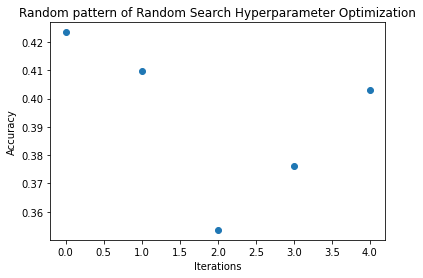

In [38]:
print("Best accuracy: " + str(best_accuracy))
# Create the scatter plot
plt.scatter(range(num_iterations), average_accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Random pattern of Random Search Hyperparameter Optimization')
plt.show()

## Evaluation 

In [124]:
# generate datasets of (text, label) stored in dictionary of topic : dataset
dataset = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    dataset[topic] = tf.data.Dataset.from_tensor_slices((features[topic], equal_labels_one_hot[topic]))
    
dataset_by_label = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    dataset_by_label[topic] = {}
    for i in range(-3, 4):
        to_be_added = {'features':[], 'equal_labels_one_hot':[]}
        for j in range(len(features[topic])):
            if equal_labels_one_hot[topic][j][i+3] == 1:
                to_be_added['features'].append(features[topic][j])
                to_be_added['equal_labels_one_hot'].append(equal_labels_one_hot[topic][j])
        dataset_by_label[topic][i] = tf.data.Dataset.from_tensor_slices((to_be_added['features'], to_be_added['equal_labels_one_hot']))

In [125]:
# split evaluation dataset from experiment dataset, the proportion is 2 : 8, still in dictionary
dataset_experiment = {}
dataset_evaluation = {}
folds = {}

# split the dataset to 5 folds
def split_dataset(dataset):
    new_dataset = dataset.shuffle(1000000)
    folds = []
    for i in range(5):
        folds.append(new_dataset.shard(num_shards=5, index=i))
    return folds
   
# split evaluation and experiment dataset and split into folds
for topic in ('answers', 'blogs', 'emails', 'news'):
    data_size = len(list(dataset[topic]))
    dataset[topic] = dataset[topic].shuffle(1000000)
    dataset_experiment[topic] = dataset[topic].take(int(data_size * 0.8))
    dataset_evaluation[topic] = dataset[topic].skip(int(data_size * 0.2))
    
    folds[topic] = split_dataset(dataset_experiment[topic])

In [126]:
# get model
model_basic = get_model(tf.keras.layers.LSTM(128, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
model_basic.summary()

topic = 'answers'

accuracy_basic = train_and_test(model_basic, 40, dataset_experiment[topic].batch(64).prefetch(tf.data.AUTOTUNE), dataset_evaluation[topic].batch(64).prefetch(tf.data.AUTOTUNE))
print(accuracy_basic)



Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3008      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_batch (Dense)         (None, 64)                8256      
                                                                 
 dense_output (Dense)        (None, 7)                 455       
                                                     

In [127]:
# Advanced Test Model untuned 

def get_untune_test_model(num_class):
    
    # Set the dimension of the embeddings
    embedding_dim = 300    
    # construct sequential model
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=embedding_dim,
            mask_zero=True, name='embedding'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, name='lstm_1')),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm_2')),
        tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
        tf.keras.layers.Dropout(0.5, name='dropout_1'),
        tf.keras.layers.Dense(num_class, activation='softmax', name='dense_output')
    ])
    # compile model
    model.compile(# use cross entropy loss
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                # fix learning rate of 0.001
                optimizer=tf.keras.optimizers.Adam(0.004),
                # evaluate the accuracy of labelling
                metrics=['accuracy'])
    return model

In [128]:
test_model= get_untune_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
test_model.summary()

topic = 'answers'
accuracy_untuned = train_and_test(test_model, 40, dataset_experiment[topic].batch(64).prefetch(tf.data.AUTOTUNE), dataset_evaluation[topic].batch(64).prefetch(tf.data.AUTOTUNE))
print(accuracy_untuned)



Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_36 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

In [129]:
best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01, 
                            tf.keras.losses.CategoricalCrossentropy(from_logits=False), tf.keras.optimizers.Adam, 
                            'selu')
best_model.summary()
topic = 'answers'
accuracy_best = train_and_test(best_model, 60, dataset_experiment[topic].batch(256).prefetch(tf.data.AUTOTUNE), dataset_evaluation[topic].batch(256).prefetch(tf.data.AUTOTUNE))
print(accuracy_best)
best_model.save(os.getcwd() + '/model/structure')
best_model.save_weights(os.getcwd() + '/model/weights')

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\1943452012.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01,


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_38 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

INFO:tensorflow:Assets written to: C:\Users\LUCAS\neuroformal/model/structure\assets


INFO:tensorflow:Assets written to: C:\Users\LUCAS\neuroformal/model/structure\assets


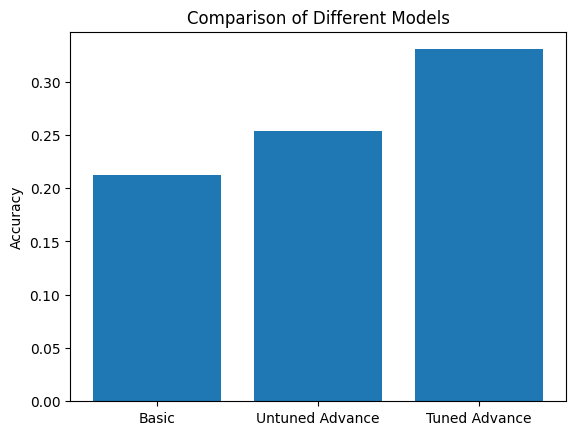

In [130]:
# Create the bar plot plotting the accuracy of the model on each fold during the 5-fold cross-validation process
plt.bar(['Basic', 'Untuned Advance', 'Tuned Advance'], [accuracy_basic, accuracy_untuned, accuracy_best])
plt.ylabel('Accuracy')
plt.title('Comparison of Different Models')
plt.show()

advanced_model_accuracy = accuracy

In [131]:
# get basic model used in sections above
model_basic = get_model(tf.keras.layers.LSTM(128, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
model_basic.summary()

topic = 'answers'

basic_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(64).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(64).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    basic_model_accuracy.append(train_and_test(model_basic, 40, train_dataset, test_dataset))
print(basic_model_accuracy)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3008      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_batch (Dense)         (None, 64)                8256      
                                                                 
 dense_output (Dense)        (None, 7)                 455       
                                                     

13/13 [==============================] - 0s 8ms/step - loss: 1.8608 - accuracy: 0.2296
Epoch 31/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8733 - accuracy: 0.2146
Epoch 32/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8835 - accuracy: 0.1932
Epoch 33/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8647 - accuracy: 0.2208
Epoch 34/40
13/13 [==============================] - 0s 8ms/step - loss: 1.8857 - accuracy: 0.1995
Epoch 35/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8554 - accuracy: 0.2271
Epoch 36/40
13/13 [==============================] - 0s 10ms/step - loss: 1.8727 - accuracy: 0.2221
Epoch 37/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8716 - accuracy: 0.2008
Epoch 38/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8588 - accuracy: 0.2233
Epoch 39/40
13/13 [==============================] - 0s 7ms/step - loss: 1.8608 - accuracy: 0.2171
Epoch 40/40
13/13 [==

In [132]:
test_model= get_untune_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
test_model.summary()

topic = 'answers'
untune_advanced_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(32).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(32).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(32).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    untune_advanced_model_accuracy.append(train_and_test(test_model, 40, train_dataset, test_dataset))
print(untune_advanced_model_accuracy)



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_40 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

25/25 [==============================] - 0s 14ms/step - loss: 1.7892 - accuracy: 0.2497
Epoch 27/40
25/25 [==============================] - 0s 15ms/step - loss: 1.8190 - accuracy: 0.2346
Epoch 28/40
25/25 [==============================] - 0s 14ms/step - loss: 1.8131 - accuracy: 0.2422
Epoch 29/40
25/25 [==============================] - 0s 15ms/step - loss: 1.7826 - accuracy: 0.2422
Epoch 30/40
25/25 [==============================] - 0s 19ms/step - loss: 1.8165 - accuracy: 0.2334
Epoch 31/40
25/25 [==============================] - 0s 15ms/step - loss: 1.7762 - accuracy: 0.2422
Epoch 32/40
25/25 [==============================] - 0s 14ms/step - loss: 1.8526 - accuracy: 0.2359
Epoch 33/40
25/25 [==============================] - 1s 20ms/step - loss: 1.8114 - accuracy: 0.2509
Epoch 34/40
25/25 [==============================] - 0s 14ms/step - loss: 1.8221 - accuracy: 0.2346
Epoch 35/40
25/25 [==============================] - 0s 15ms/step - loss: 1.8212 - accuracy: 0.2221
Epoch 36/40


In [133]:
# Tuned Model with the best hyper parameters determined
best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01, 
                            tf.keras.losses.CategoricalCrossentropy(from_logits=False), tf.keras.optimizers.Adam, 
                            'selu')
best_model.summary()

topic = 'answers'
tuned_advanced_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(256).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(256).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(256).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    tuned_advanced_model_accuracy.append(train_and_test(best_model, 60, train_dataset, test_dataset))
print(tuned_advanced_model_accuracy)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\2277152278.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01,


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_42 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_43 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

4/4 [==============================] - 0s 18ms/step - loss: 1.8644 - accuracy: 0.2196
Epoch 9/60
4/4 [==============================] - 0s 17ms/step - loss: 1.8562 - accuracy: 0.2108
Epoch 10/60
4/4 [==============================] - 0s 18ms/step - loss: 1.8665 - accuracy: 0.2183
Epoch 11/60
4/4 [==============================] - 0s 19ms/step - loss: 1.8861 - accuracy: 0.2083
Epoch 12/60
4/4 [==============================] - 0s 19ms/step - loss: 1.8606 - accuracy: 0.2346
Epoch 13/60
4/4 [==============================] - 0s 16ms/step - loss: 1.8760 - accuracy: 0.1957
Epoch 14/60
4/4 [==============================] - 0s 22ms/step - loss: 1.8612 - accuracy: 0.2008
Epoch 15/60
4/4 [==============================] - 0s 16ms/step - loss: 1.8705 - accuracy: 0.2334
Epoch 16/60
4/4 [==============================] - 0s 16ms/step - loss: 1.8578 - accuracy: 0.2083
Epoch 17/60
4/4 [==============================] - 0s 16ms/step - loss: 1.8314 - accuracy: 0.2472
Epoch 18/60
4/4 [================

Epoch 31/60
4/4 [==============================] - 0s 16ms/step - loss: 1.8194 - accuracy: 0.2522
Epoch 32/60
4/4 [==============================] - 0s 13ms/step - loss: 1.8284 - accuracy: 0.2309
Epoch 33/60
4/4 [==============================] - 0s 18ms/step - loss: 1.8558 - accuracy: 0.2309
Epoch 34/60
4/4 [==============================] - 0s 15ms/step - loss: 1.8125 - accuracy: 0.2484
Epoch 35/60
4/4 [==============================] - 0s 17ms/step - loss: 1.8009 - accuracy: 0.2346
Epoch 36/60
4/4 [==============================] - 0s 53ms/step - loss: 1.8139 - accuracy: 0.2371
Epoch 37/60
4/4 [==============================] - 0s 19ms/step - loss: 1.8305 - accuracy: 0.2472
Epoch 38/60
4/4 [==============================] - 0s 17ms/step - loss: 1.8742 - accuracy: 0.2246
Epoch 39/60
4/4 [==============================] - 0s 20ms/step - loss: 1.8340 - accuracy: 0.2346
Epoch 40/60
4/4 [==============================] - 0s 25ms/step - loss: 1.8547 - accuracy: 0.2497
Epoch 41/60
4/4 [===

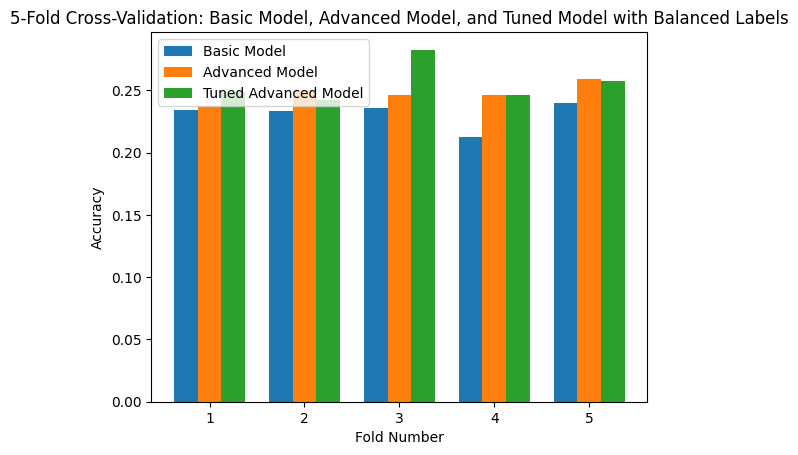

In [134]:
# Set up the plot
num_folds = 5
fold_numbers = np.arange(1, num_folds + 1)
bar_width = 0.25

# Create the grouped bar plot
fig, ax = plt.subplots()
basic_model_bars = ax.bar(fold_numbers - bar_width, basic_model_accuracy, bar_width, label='Basic Model')
advanced_model_bars = ax.bar(fold_numbers, untune_advanced_model_accuracy, bar_width, label='Advanced Model')
tuned_model_bars = ax.bar(fold_numbers + bar_width, tuned_advanced_model_accuracy, bar_width, label='Tuned Advanced Model')

# Add labels, title, and legend
ax.set_xlabel('Fold Number')
ax.set_ylabel('Accuracy')
ax.set_title('5-Fold Cross-Validation: Basic Model, Advanced Model, and Tuned Model with Balanced Labels')
ax.legend()

# Display the plot
plt.show()

In [139]:
eval_dataset_by_label = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    eval_data = np.array(list(dataset_evaluation[topic].as_numpy_iterator()), dtype=object)
    eval_dataset_by_label[topic] = {}
    for i in range(-3, 4):
        to_be_added = {'features':[], 'equal_labels_one_hot':[]}
        for j in range(len(features[topic])):
            if equal_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:
                to_be_added['features'].append(features[topic][j])
                to_be_added['equal_labels_one_hot'].append(equal_labels_one_hot[topic][j])
        eval_dataset_by_label[topic][i] = tf.data.Dataset.from_tensor_slices((to_be_added['features'], to_be_added['equal_labels_one_hot']))

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\2836668648.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if equal_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:


In [140]:
basic_model_accuracy_by_label = []
untune_advanced_model_accuracy_by_label = []
tuned_advanced_model_accuracy_by_label = []
for i in range(-3, 4):
    print(eval_dataset_by_label[topic][i])
    labelled_test_dataset = eval_dataset_by_label[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    basic_model_accuracy_by_label.append(model_basic.evaluate(labelled_test_dataset)[1])
    untune_advanced_model_accuracy_by_label.append(test_model.evaluate(labelled_test_dataset)[1])
    tuned_advanced_model_accuracy_by_label.append(best_model.evaluate(labelled_test_dataset)[1])

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>
6/6 [==============================] - 0s 10ms/step - loss: 2.3402 - accuracy: 0.0324
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>
7/7 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.0362
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>
3/3 [==============================] - 0s 9ms/step - loss: 2.0344 - accuracy: 0.0109
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>
7/7 [==============================] - 0s 9ms/step - loss: 2.2873 - accuracy: 0.0023
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf

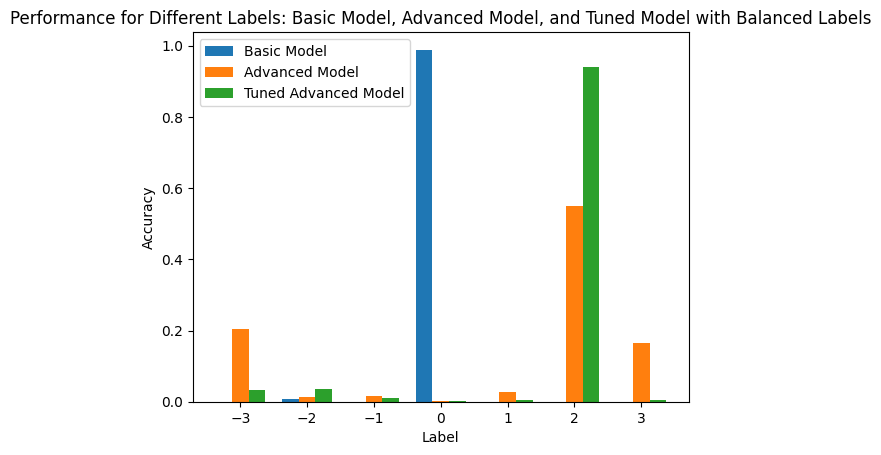

In [141]:
# Set up the plot
label_numbers = np.arange(-3, 4)
bar_width = 0.25

# Create the grouped bar plot
fig, ax = plt.subplots()
basic_model_bars = ax.bar(label_numbers - bar_width, basic_model_accuracy_by_label, bar_width, label='Basic Model')
advanced_model_bars = ax.bar(label_numbers, untune_advanced_model_accuracy_by_label, bar_width, label='Advanced Model')
tuned_model_bars = ax.bar(label_numbers + bar_width, tuned_advanced_model_accuracy_by_label, bar_width, label='Tuned Advanced Model')

# Add labels, title, and legend
ax.set_xlabel('Label')
ax.set_ylabel('Accuracy')
ax.set_title('Performance for Different Labels: Basic Model, Advanced Model, and Tuned Model with Balanced Labels')
ax.legend()

# Display the plot
plt.show()

In [142]:
dataset = {}
for topic in ('answers', 'blogs', 'emails', 'news'):
    dataset[topic] = tf.data.Dataset.from_tensor_slices((features[topic], multi_labels_one_hot[topic]))
    
# split evaluation dataset from experiment dataset, the proportion is 2 : 8, still in dictionary
dataset_experiment = {}
dataset_evaluation = {}
folds = {}

# split the dataset to 5 folds
def split_dataset(dataset):
    new_dataset = dataset.shuffle(1000000)
    folds = []
    for i in range(5):
        folds.append(new_dataset.shard(num_shards=5, index=i))
    return folds
   
# split evaluation and experiment dataset and split into folds
for topic in ('answers', 'blogs', 'emails', 'news'):
    data_size = len(list(dataset[topic]))
    dataset[topic] = dataset[topic].shuffle(1000000)
    dataset_experiment[topic] = dataset[topic].take(int(data_size * 0.8))
    dataset_evaluation[topic] = dataset[topic].skip(int(data_size * 0.2))
    
    folds[topic] = split_dataset(dataset_experiment[topic])
    
    eval_dataset_by_label = {}

for topic in ('answers', 'blogs', 'emails', 'news'):
    eval_data = np.array(list(dataset_evaluation[topic].as_numpy_iterator()), dtype=object)
    eval_dataset_by_label[topic] = {}
    for i in range(-3, 4):
        to_be_added = {'features':[], 'multi_labels_one_hot':[]}
        for j in range(len(features[topic])):
            if multi_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:
                to_be_added['features'].append(features[topic][j])
                to_be_added['multi_labels_one_hot'].append(multi_labels_one_hot[topic][j])
        eval_dataset_by_label[topic][i] = tf.data.Dataset.from_tensor_slices((to_be_added['features'], to_be_added['multi_labels_one_hot']))

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\1201397064.py:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if multi_labels_one_hot[topic][j][i+3] == 1 and str.encode(features[topic][j]) in eval_data:


In [143]:
# get basic model used in sections above
model_basic = get_model(tf.keras.layers.LSTM(128, name='lstm'), 64, len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
model_basic.summary()

topic = 'answers'

basic_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(64).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(64).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(64).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    basic_model_accuracy.append(train_and_test(model_basic, 40, train_dataset, test_dataset))
print(basic_model_accuracy)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3008      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_batch (Dense)         (None, 64)                8256      
                                                                 
 dense_output (Dense)        (None, 7)                 455       
                                                     

13/13 [==============================] - 0s 9ms/step - loss: 1.6724 - accuracy: 0.2735
Epoch 31/40
13/13 [==============================] - 0s 6ms/step - loss: 1.7423 - accuracy: 0.2560
Epoch 32/40
13/13 [==============================] - 0s 7ms/step - loss: 1.6974 - accuracy: 0.2861
Epoch 33/40
13/13 [==============================] - 0s 7ms/step - loss: 1.7036 - accuracy: 0.2861
Epoch 34/40
13/13 [==============================] - 0s 9ms/step - loss: 1.6759 - accuracy: 0.2949
Epoch 35/40
13/13 [==============================] - 0s 11ms/step - loss: 1.7268 - accuracy: 0.2384
Epoch 36/40
13/13 [==============================] - 0s 7ms/step - loss: 1.7069 - accuracy: 0.2760
Epoch 37/40
13/13 [==============================] - 0s 7ms/step - loss: 1.6899 - accuracy: 0.2735
Epoch 38/40
13/13 [==============================] - 0s 7ms/step - loss: 1.7023 - accuracy: 0.2811
Epoch 39/40
13/13 [==============================] - 0s 7ms/step - loss: 1.6937 - accuracy: 0.2673
Epoch 40/40
13/13 [==

In [144]:
test_model= get_untune_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()),dtype=object)[0, 1]))
test_model.summary()

topic = 'answers'
untune_advanced_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(32).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(32).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(32).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    untune_advanced_model_accuracy.append(train_and_test(test_model, 40, train_dataset, test_dataset))
print(untune_advanced_model_accuracy)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_44 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_45 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

25/25 [==============================] - 0s 15ms/step - loss: 1.6564 - accuracy: 0.2911
Epoch 27/40
25/25 [==============================] - 0s 14ms/step - loss: 1.6195 - accuracy: 0.3212
Epoch 28/40
25/25 [==============================] - 0s 14ms/step - loss: 1.6903 - accuracy: 0.2660
Epoch 29/40
25/25 [==============================] - 0s 14ms/step - loss: 1.6560 - accuracy: 0.2811
Epoch 30/40
25/25 [==============================] - 0s 15ms/step - loss: 1.6131 - accuracy: 0.3074
Epoch 31/40
25/25 [==============================] - 0s 14ms/step - loss: 1.6682 - accuracy: 0.2572
Epoch 32/40
25/25 [==============================] - 0s 15ms/step - loss: 1.6614 - accuracy: 0.2861
Epoch 33/40
25/25 [==============================] - 0s 15ms/step - loss: 1.6220 - accuracy: 0.3187
Epoch 34/40
25/25 [==============================] - 0s 15ms/step - loss: 1.6972 - accuracy: 0.2597
Epoch 35/40
25/25 [==============================] - 0s 14ms/step - loss: 1.6330 - accuracy: 0.3124
Epoch 36/40


In [145]:
# Tuned Model with the best hyper parameters determined
best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01, 
                            tf.keras.losses.CategoricalCrossentropy(from_logits=False), tf.keras.optimizers.Adam, 
                            'selu')
best_model.summary()

topic = 'answers'
tuned_advanced_model_accuracy = []
for i in range(5):
    # folds to datasets
    # one fold as test dataset
    test_dataset = folds[topic][i].batch(256).prefetch(tf.data.AUTOTUNE)
    iterator = [j for j in range(5) if j != i]
    # the rest as train dataset
    train_dataset = folds[topic][iterator[0]].batch(256).prefetch(tf.data.AUTOTUNE)
    for j in iterator[1:]:
        train_dataset.concatenate(folds[topic][j].batch(256).prefetch(tf.data.AUTOTUNE))
    # begin the process of train and test
    tuned_advanced_model_accuracy.append(train_and_test(best_model, 60, train_dataset, test_dataset))
print(tuned_advanced_model_accuracy)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18956\2277152278.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_model = get_test_model(len(np.array(list(dataset['answers'].as_numpy_iterator()))[0, 1]), 300, 0.01,


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 300)         14100     
                                                                 
 bidirectional_46 (Bidirecti  (None, None, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_47 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                     

4/4 [==============================] - 0s 16ms/step - loss: 1.6692 - accuracy: 0.2785
Epoch 9/60
4/4 [==============================] - 0s 17ms/step - loss: 1.7152 - accuracy: 0.2409
Epoch 10/60
4/4 [==============================] - 0s 22ms/step - loss: 1.6973 - accuracy: 0.2760
Epoch 11/60
4/4 [==============================] - 0s 12ms/step - loss: 1.6727 - accuracy: 0.2560
Epoch 12/60
4/4 [==============================] - 0s 19ms/step - loss: 1.7029 - accuracy: 0.2760
Epoch 13/60
4/4 [==============================] - 0s 20ms/step - loss: 1.6687 - accuracy: 0.2760
Epoch 14/60
4/4 [==============================] - 0s 17ms/step - loss: 1.6913 - accuracy: 0.2497
Epoch 15/60
4/4 [==============================] - 0s 16ms/step - loss: 1.6904 - accuracy: 0.2547
Epoch 16/60
4/4 [==============================] - 0s 16ms/step - loss: 1.7042 - accuracy: 0.2509
Epoch 17/60
4/4 [==============================] - 0s 16ms/step - loss: 1.6777 - accuracy: 0.2723
Epoch 18/60
4/4 [================

Epoch 31/60
4/4 [==============================] - 0s 21ms/step - loss: 1.6812 - accuracy: 0.2585
Epoch 32/60
4/4 [==============================] - 0s 12ms/step - loss: 1.6541 - accuracy: 0.2685
Epoch 33/60
4/4 [==============================] - 0s 16ms/step - loss: 1.6767 - accuracy: 0.2585
Epoch 34/60
4/4 [==============================] - 0s 16ms/step - loss: 1.7054 - accuracy: 0.2823
Epoch 35/60
4/4 [==============================] - 0s 52ms/step - loss: 1.6785 - accuracy: 0.2886
Epoch 36/60
4/4 [==============================] - 0s 17ms/step - loss: 1.6831 - accuracy: 0.2936
Epoch 37/60
4/4 [==============================] - 0s 16ms/step - loss: 1.7068 - accuracy: 0.2585
Epoch 38/60
4/4 [==============================] - 0s 18ms/step - loss: 1.6663 - accuracy: 0.2986
Epoch 39/60
4/4 [==============================] - 0s 18ms/step - loss: 1.6514 - accuracy: 0.2735
Epoch 40/60
4/4 [==============================] - 0s 19ms/step - loss: 1.6616 - accuracy: 0.2572
Epoch 41/60
4/4 [===

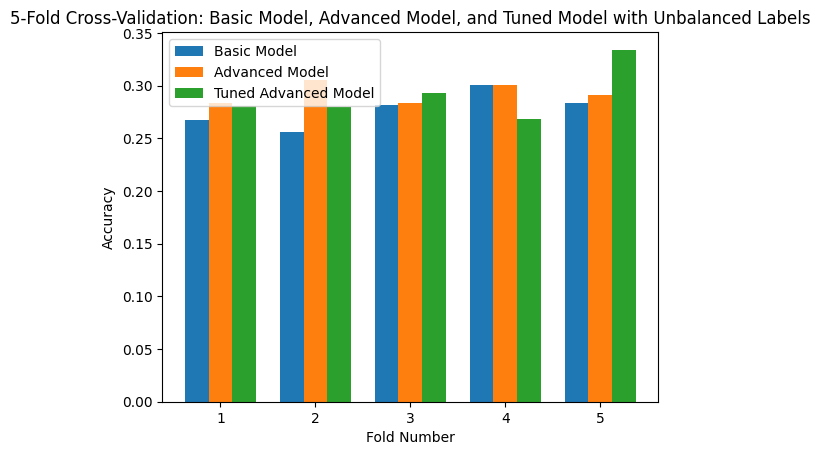

In [146]:
# Set up the plot
num_folds = 5
fold_numbers = np.arange(1, num_folds + 1)
bar_width = 0.25

# Create the grouped bar plot
fig, ax = plt.subplots()
basic_model_bars = ax.bar(fold_numbers - bar_width, basic_model_accuracy, bar_width, label='Basic Model')
advanced_model_bars = ax.bar(fold_numbers, untune_advanced_model_accuracy, bar_width, label='Advanced Model')
tuned_model_bars = ax.bar(fold_numbers + bar_width, tuned_advanced_model_accuracy, bar_width, label='Tuned Advanced Model')

# Add labels, title, and legend
ax.set_xlabel('Fold Number')
ax.set_ylabel('Accuracy')
ax.set_title('5-Fold Cross-Validation: Basic Model, Advanced Model, and Tuned Model with Unbalanced Labels')
ax.legend()

# Display the plot
plt.show()

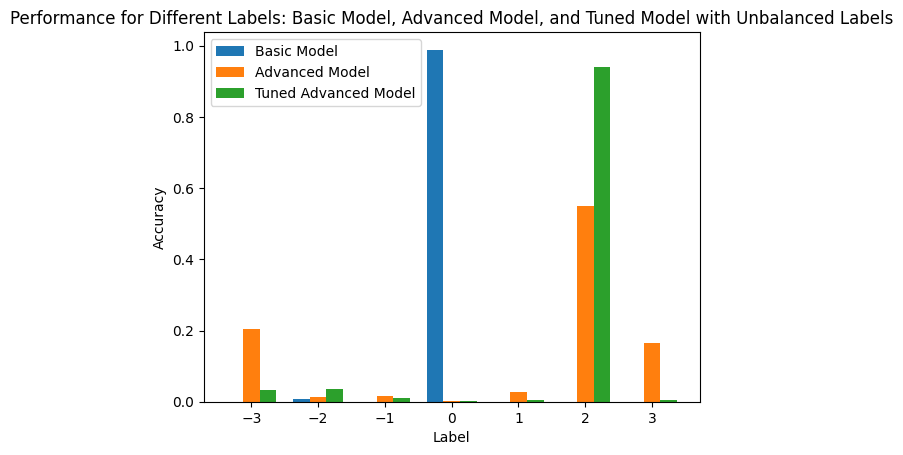

In [147]:
# Set up the plot
label_numbers = np.arange(-3, 4)
bar_width = 0.25

# Create the grouped bar plot
fig, ax = plt.subplots()
basic_model_bars = ax.bar(label_numbers - bar_width, basic_model_accuracy_by_label, bar_width, label='Basic Model')
advanced_model_bars = ax.bar(label_numbers, untune_advanced_model_accuracy_by_label, bar_width, label='Advanced Model')
tuned_model_bars = ax.bar(label_numbers + bar_width, tuned_advanced_model_accuracy_by_label, bar_width, label='Tuned Advanced Model')

# Add labels, title, and legend
ax.set_xlabel('Label')
ax.set_ylabel('Accuracy')
ax.set_title('Performance for Different Labels: Basic Model, Advanced Model, and Tuned Model with Unbalanced Labels')
ax.legend()

# Display the plot
plt.show()